In [1]:
import os
import sys
# Add src/ to sys.path (relative to current notebook)
sys.path.append(os.path.abspath("../../src"))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pathlib
import re

from utils.DataAnalysis import TableAnalysis, MyCustomException
from utils.VariableAnalysis import UnivariateAnalysis,BivariateAnalysis
from utils.pdf_file_save import PDFReportWriter

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns',None)

In [2]:
file_path = pathlib.Path('D:\Capstone Project\dataset\House_Price_dataset')
df = pd.read_csv(f"{file_path}/4.gurgaon_properties_cleaned_v1.csv")
df.head()

,property_type,society,sector,price,price_per_sqft,area,areaWithType,bedRoom,bathroom,balcony,additionalRoom,floorNum,facing,agePossession,nearbyLocations,furnishDetails,features
0,flat,apna enclave,sector 3,8.00,6153.0,13002.0,Super Built up area 1300(120.77 sq.m.)Built Up...,3,3,1,not available,0.0,NaN,10+ Year Old,"['Chintapurni Mandir', 'Sheetla Mata Mandir', ...",NaN,NaN
1,flat,la vida by tata housing,sector 113,2.00,11346.0,1763.0,Super Built up area 2690(249.91 sq.m.)Built Up...,3,3,3,"study room,servant room",3.0,North,0 to 1 Year Old,"['Dwarka Sector 21', 'Pacific D21 Mall', 'Bajg...","['2 Light', 'No AC', 'No Bed', 'No Chimney', '...","['Centrally Air Conditioned', 'Water purifier'..."
2,house,independent,sector 56,3.25,21495.0,1512.0,Plot area 168(140.47 sq.m.),5,6,3+,"pooja room,others",4.0,East,1 to 5 Year Old,"['Sector metro station', 'Sector metro station...","['7 Wardrobe', '3 Fan', '1 Exhaust Fan', '8 Li...","['Maintenance Staff', 'Water Storage', 'Visito..."
3,flat,g l s arawali homes,sohna road,2.00,4513.0,4432.0,Super Built up area 576(53.51 sq.m.),2,2,2,not available,1.0,NaN,5 to 10 Year Old,NaN,[],NaN
4,flat,tarc maceo,sector 91,9.00,5413.0,16627.0,Super Built up area 1404(130.44 sq.m.),2,2,3+,not available,8.0,East,5 to 10 Year Old,"['Manish Gallexie 91', 'Dwarka Expressway', 'R...","['2 Wardrobe', '4 Fan', '2 Geyser', '11 Light'...","['Security / Fire Alarm', 'Intercom Facility',..."


In [3]:
df.duplicated().sum()

np.int64(122)

In [4]:
df.head(1)
# focus is on -> areaWithType, additionalRoom, agePossession, furnishDetails, features 

,property_type,society,sector,price,price_per_sqft,area,areaWithType,bedRoom,bathroom,balcony,additionalRoom,floorNum,facing,agePossession,nearbyLocations,furnishDetails,features
0,flat,apna enclave,sector 3,8.0,6153.0,13002.0,Super Built up area 1300(120.77 sq.m.)Built Up...,3,3,1,not available,0.0,NaN,10+ Year Old,"['Chintapurni Mandir', 'Sheetla Mata Mandir', ...",NaN,NaN


## 1. areaWithType

In [5]:
df.sample(5)[['price','area','areaWithType']]

,price,area,areaWithType
1091,8.00,13502.0,Built Up area: 1350 (125.42 sq.m.)
377,2.00,1284.0,Built Up area: 2060 (191.38 sq.m.)Carpet area:...
2280,6.75,4500.0,Built Up area: 4500 (418.06 sq.m.)
1196,1.00,1740.0,Super Built up area 1740(161.65 sq.m.)
2231,0.47,1336.0,Built Up area: 1350 (125.42 sq.m.)


In [6]:
# This function extracts the Super Built up area
def get_super_built_up_area(text):
    match = re.search(r'Super Built up area (\d+\.?\d*)', text)
    if match:
        return float(match.group(1))
    return None

In [7]:
# This function extracts the Built Up area or Carpet area
def get_area(text, area_type):
    match = re.search(area_type + r'\s*:\s*(\d+\.?\d*)', text)
    if match:
        return float(match.group(1))
    return None

In [8]:
# This function checks if the area is provided in sq.m. and converts it to sqft if needed
def convert_to_sqft(text, area_value):
    if area_value is None:
        return None
    match = re.search(r'{} \((\d+\.?\d*) sq.m.\)'.format(area_value), text)
    if match:
        sq_m_value = float(match.group(1))
        return sq_m_value * 10.7639  # conversion factor from sq.m. to sqft
    return area_value

In [9]:
# Extract Super Built up area and convert to sqft if needed
df['super_built_up_area'] = df['areaWithType'].apply(get_super_built_up_area)

df['super_built_up_area'] = df.apply(lambda x: convert_to_sqft(x['areaWithType'], x['super_built_up_area']), axis=1)

# Extract Built Up area and convert to sqft if needed
df['built_up_area'] = df['areaWithType'].apply(lambda x: get_area(x, 'Built Up area'))
df['built_up_area'] = df.apply(lambda x: convert_to_sqft(x['areaWithType'], x['built_up_area']), axis=1)

# Extract Carpet area and convert to sqft if needed
df['carpet_area'] = df['areaWithType'].apply(lambda x: get_area(x, 'Carpet area'))
df['carpet_area'] = df.apply(lambda x: convert_to_sqft(x['areaWithType'], x['carpet_area']), axis=1)

In [10]:
df[['price','property_type','area','areaWithType','super_built_up_area','built_up_area','carpet_area']].sample(5)

,price,property_type,area,areaWithType,super_built_up_area,built_up_area,carpet_area
189,1.0,flat,1043.0,Built Up area: 1825 (169.55 sq.m.),NaN,1825.0,NaN
1310,4.0,flat,6087.0,Carpet area: 700 (65.03 sq.m.),NaN,NaN,700.0
2758,7.0,flat,11636.0,Carpet area: 1230 (114.27 sq.m.),NaN,NaN,1230.0
1587,7.0,flat,21154.0,Super Built up area 2115(196.49 sq.m.),2115.0,NaN,NaN
472,1.0,flat,939.0,Carpet area: 1596 (148.27 sq.m.),NaN,NaN,1596.0


In [11]:
df.duplicated().sum()

np.int64(122)

In [12]:
df[~((df['super_built_up_area'].isnull()) | (df['built_up_area'].isnull()) | (df['carpet_area'].isnull()))][['price','property_type','area','areaWithType','super_built_up_area','built_up_area','carpet_area']].shape

(534, 7)

In [13]:
## Property type House has Plot Area

df[df['areaWithType'].str.contains('Plot')][['price','property_type','area','areaWithType','super_built_up_area','built_up_area','carpet_area']]

,price,property_type,area,areaWithType,super_built_up_area,built_up_area,carpet_area
2,3.25,house,1512.0,Plot area 168(140.47 sq.m.),NaN,NaN,NaN
10,2.90,house,1557.0,Plot area 173(144.65 sq.m.)Built Up area: 1415...,NaN,1415.0,1350.0
11,0.75,house,1095.0,Plot area 1095(101.73 sq.m.),NaN,NaN,NaN
15,0.47,house,443.0,Plot area 49(40.97 sq.m.)Built Up area: 50 sq....,NaN,50.0,48.0
19,2.10,house,549.0,Plot area 61(51 sq.m.),NaN,NaN,NaN
...,...,...,...,...,...,...,...
3782,3.85,house,2628.0,Plot area 292(244.15 sq.m.),NaN,NaN,NaN
3788,0.38,house,900.0,Plot area 900(83.61 sq.m.),NaN,NaN,NaN
3791,5.00,house,1125.0,Plot area 125(104.52 sq.m.)Built Up area: 115 ...,NaN,115.0,100.0
3793,12.50,house,4687.0,Plot area 500(418.06 sq.m.),NaN,NaN,NaN


In [14]:
df.isnull().sum()

property_type             0
society                   1
sector                    0
price                    18
price_per_sqft           18
area                     18
areaWithType              0
bedRoom                   0
bathroom                  0
balcony                   0
additionalRoom            0
floorNum                 19
facing                 1105
agePossession             1
nearbyLocations         177
furnishDetails          981
features                635
super_built_up_area    1888
built_up_area          2616
carpet_area            1859
dtype: int64

In [15]:
## Nan Value for all newly Created Columns [super_built_up_area,built_up_area,carpet_area]
all_nan_df = df[((df['super_built_up_area'].isnull()) & (df['built_up_area'].isnull()) & (df['carpet_area'].isnull()))][['price','property_type','area','areaWithType','super_built_up_area','built_up_area','carpet_area']]

In [16]:
all_nan_df.head()

,price,property_type,area,areaWithType,super_built_up_area,built_up_area,carpet_area
2,3.25,house,1512.0,Plot area 168(140.47 sq.m.),NaN,NaN,NaN
11,0.75,house,1095.0,Plot area 1095(101.73 sq.m.),NaN,NaN,NaN
19,2.10,house,549.0,Plot area 61(51 sq.m.),NaN,NaN,NaN
20,1.07,house,900.0,Plot area 900(83.61 sq.m.),NaN,NaN,NaN
21,1.10,house,1800.0,Plot area 200(167.23 sq.m.),NaN,NaN,NaN


In [17]:
all_nan_index = df[((df['super_built_up_area'].isnull()) & (df['built_up_area'].isnull()) & (df['carpet_area'].isnull()))][['price','property_type','area','areaWithType','super_built_up_area','built_up_area','carpet_area']].index

In [18]:
# Function to extract plot area from 'areaWithType' column
def extract_plot_area(area_with_type):
    match = re.search(r'Plot area (\d+\.?\d*)', area_with_type)
    return float(match.group(1)) if match else None

In [19]:
all_nan_df['built_up_area'] = all_nan_df['areaWithType'].apply(extract_plot_area)

# Update the original dataframe
#gurgaon_properties.update(filtered_rows)

In [20]:
all_nan_df.head()

,price,property_type,area,areaWithType,super_built_up_area,built_up_area,carpet_area
2,3.25,house,1512.0,Plot area 168(140.47 sq.m.),NaN,168.0,NaN
11,0.75,house,1095.0,Plot area 1095(101.73 sq.m.),NaN,1095.0,NaN
19,2.10,house,549.0,Plot area 61(51 sq.m.),NaN,61.0,NaN
20,1.07,house,900.0,Plot area 900(83.61 sq.m.),NaN,900.0,NaN
21,1.10,house,1800.0,Plot area 200(167.23 sq.m.),NaN,200.0,NaN


In [21]:
## Recalculating build up Area in to sq FEET  Metric since some areas are given in square yard.

def convert_scale(row):
    if np.isnan(row['area']) or np.isnan(row['built_up_area']):
        return row['built_up_area']
    else:
        if round(row['area']/row['built_up_area']) == 9.0:
            return row['built_up_area'] * 9
        elif round(row['area']/row['built_up_area']) == 11.0:
            return row['built_up_area'] * 10.7
        else:
            return row['built_up_area']

In [22]:
all_nan_df['built_up_area'] = all_nan_df.apply(convert_scale,axis=1)

In [23]:
all_nan_df

,price,property_type,area,areaWithType,super_built_up_area,built_up_area,carpet_area
2,3.25,house,1512.0,Plot area 168(140.47 sq.m.),NaN,1512.0,NaN
11,0.75,house,1095.0,Plot area 1095(101.73 sq.m.),NaN,1095.0,NaN
19,2.10,house,549.0,Plot area 61(51 sq.m.),NaN,549.0,NaN
20,1.07,house,900.0,Plot area 900(83.61 sq.m.),NaN,900.0,NaN
21,1.10,house,1800.0,Plot area 200(167.23 sq.m.),NaN,1800.0,NaN
...,...,...,...,...,...,...,...
3780,3.90,house,1836.0,Plot area 204(170.57 sq.m.),NaN,1836.0,NaN
3782,3.85,house,2628.0,Plot area 292(244.15 sq.m.),NaN,2628.0,NaN
3788,0.38,house,900.0,Plot area 900(83.61 sq.m.),NaN,900.0,NaN
3793,12.50,house,4687.0,Plot area 500(418.06 sq.m.),NaN,4500.0,NaN


In [24]:
# update the original dataframe
df.update(all_nan_df)

In [25]:
df.isnull().sum()

property_type             0
society                   1
sector                    0
price                    18
price_per_sqft           18
area                     18
areaWithType              0
bedRoom                   0
bathroom                  0
balcony                   0
additionalRoom            0
floorNum                 19
facing                 1105
agePossession             1
nearbyLocations         177
furnishDetails          981
features                635
super_built_up_area    1888
built_up_area          2070
carpet_area            1859
dtype: int64

In [26]:
df.head()

,property_type,society,sector,price,price_per_sqft,area,areaWithType,bedRoom,bathroom,balcony,additionalRoom,floorNum,facing,agePossession,nearbyLocations,furnishDetails,features,super_built_up_area,built_up_area,carpet_area
0,flat,apna enclave,sector 3,8.00,6153.0,13002.0,Super Built up area 1300(120.77 sq.m.)Built Up...,3,3,1,not available,0.0,NaN,10+ Year Old,"['Chintapurni Mandir', 'Sheetla Mata Mandir', ...",NaN,NaN,1300.0,1000.0,NaN
1,flat,la vida by tata housing,sector 113,2.00,11346.0,1763.0,Super Built up area 2690(249.91 sq.m.)Built Up...,3,3,3,"study room,servant room",3.0,North,0 to 1 Year Old,"['Dwarka Sector 21', 'Pacific D21 Mall', 'Bajg...","['2 Light', 'No AC', 'No Bed', 'No Chimney', '...","['Centrally Air Conditioned', 'Water purifier'...",2690.0,2599.0,2450.0
2,house,independent,sector 56,3.25,21495.0,1512.0,Plot area 168(140.47 sq.m.),5,6,3+,"pooja room,others",4.0,East,1 to 5 Year Old,"['Sector metro station', 'Sector metro station...","['7 Wardrobe', '3 Fan', '1 Exhaust Fan', '8 Li...","['Maintenance Staff', 'Water Storage', 'Visito...",NaN,1512.0,NaN
3,flat,g l s arawali homes,sohna road,2.00,4513.0,4432.0,Super Built up area 576(53.51 sq.m.),2,2,2,not available,1.0,NaN,5 to 10 Year Old,NaN,[],NaN,576.0,NaN,NaN
4,flat,tarc maceo,sector 91,9.00,5413.0,16627.0,Super Built up area 1404(130.44 sq.m.),2,2,3+,not available,8.0,East,5 to 10 Year Old,"['Manish Gallexie 91', 'Dwarka Expressway', 'R...","['2 Wardrobe', '4 Fan', '2 Geyser', '11 Light'...","['Security / Fire Alarm', 'Intercom Facility',...",1404.0,NaN,NaN


## 2.additionalRoom

In [27]:
df['additionalRoom'].value_counts()

additionalRoom
not available                                    1587
servant room                                      705
study room                                        250
others                                            225
pooja room                                        165
                                                 ... 
servant room,study room,store room,pooja room       1
servant room,store room,study room,pooja room       1
others,study room                                   1
store room,study room                               1
servant room,pooja room,study room                  1
Name: count, Length: 65, dtype: int64

In [28]:
# additional room
# List of new columns to be created
new_cols = ['study room', 'servant room', 'store room', 'pooja room', 'others']

# Populate the new columns based on the "additionalRoom" column
for col in new_cols:
    df[col] = df['additionalRoom'].str.contains(col).astype(int)

In [29]:
df.sample(5)[['additionalRoom','study room', 'servant room', 'store room', 'pooja room', 'others']]

,additionalRoom,study room,servant room,store room,pooja room,others
592,not available,0,0,0,0,0
1891,not available,0,0,0,0,0
1837,"servant room,others",0,1,0,0,1
393,not available,0,0,0,0,0
3116,"servant room,store room",0,1,1,0,0


In [30]:
df.head()

,property_type,society,sector,price,price_per_sqft,area,areaWithType,bedRoom,bathroom,balcony,additionalRoom,floorNum,facing,agePossession,nearbyLocations,furnishDetails,features,super_built_up_area,built_up_area,carpet_area,study room,servant room,store room,pooja room,others
0,flat,apna enclave,sector 3,8.00,6153.0,13002.0,Super Built up area 1300(120.77 sq.m.)Built Up...,3,3,1,not available,0.0,NaN,10+ Year Old,"['Chintapurni Mandir', 'Sheetla Mata Mandir', ...",NaN,NaN,1300.0,1000.0,NaN,0,0,0,0,0
1,flat,la vida by tata housing,sector 113,2.00,11346.0,1763.0,Super Built up area 2690(249.91 sq.m.)Built Up...,3,3,3,"study room,servant room",3.0,North,0 to 1 Year Old,"['Dwarka Sector 21', 'Pacific D21 Mall', 'Bajg...","['2 Light', 'No AC', 'No Bed', 'No Chimney', '...","['Centrally Air Conditioned', 'Water purifier'...",2690.0,2599.0,2450.0,1,1,0,0,0
2,house,independent,sector 56,3.25,21495.0,1512.0,Plot area 168(140.47 sq.m.),5,6,3+,"pooja room,others",4.0,East,1 to 5 Year Old,"['Sector metro station', 'Sector metro station...","['7 Wardrobe', '3 Fan', '1 Exhaust Fan', '8 Li...","['Maintenance Staff', 'Water Storage', 'Visito...",NaN,1512.0,NaN,0,0,0,1,1
3,flat,g l s arawali homes,sohna road,2.00,4513.0,4432.0,Super Built up area 576(53.51 sq.m.),2,2,2,not available,1.0,NaN,5 to 10 Year Old,NaN,[],NaN,576.0,NaN,NaN,0,0,0,0,0
4,flat,tarc maceo,sector 91,9.00,5413.0,16627.0,Super Built up area 1404(130.44 sq.m.),2,2,3+,not available,8.0,East,5 to 10 Year Old,"['Manish Gallexie 91', 'Dwarka Expressway', 'R...","['2 Wardrobe', '4 Fan', '2 Geyser', '11 Light'...","['Security / Fire Alarm', 'Intercom Facility',...",1404.0,NaN,NaN,0,0,0,0,0


## 3.agePossession

In [31]:
df['agePossession'].value_counts()

agePossession
1 to 5 Year Old       1676
5 to 10 Year Old       575
0 to 1 Year Old        530
undefined              332
10+ Year Old           310
Under Construction      90
Within 6 months         70
Within 3 months         26
Dec 2023                22
By 2023                 19
By 2024                 17
Dec 2024                16
Mar 2024                14
Oct 2024                 8
Jan 2024                 8
Aug 2023                 7
Jun 2024                 7
Dec 2025                 7
Nov 2023                 5
Sep 2023                 4
By 2025                  4
Aug 2024                 4
Oct 2023                 4
Jul 2024                 4
Nov 2024                 3
May 2024                 3
Jan 2025                 3
Feb 2024                 3
Jul 2025                 2
Aug 2025                 2
Oct 2025                 2
Jul 2027                 2
Dec 2026                 2
By 2027                  2
Sep 2025                 2
Jun 2027                 2
Mar 2025      

In [32]:
## categorical valu of agePossesion Binning in to category 

def categorize_age_possession(value):
    if pd.isna(value):
        return "Undefined"
    if "0 to 1 Year Old" in value or "Within 6 months" in value or "Within 3 months" in value:
        return "New Property"
    if "1 to 5 Year Old" in value:
        return "Relatively New"
    if "5 to 10 Year Old" in value:
        return "Moderately Old"
    if "10+ Year Old" in value:
        return "Old Property"
    if "Under Construction" in value or "By" in value:
        return "Under Construction"
    try:
        # For entries like 'May 2024'
        int(value.split(" ")[-1])
        return "Under Construction"
    except:
        return "Undefined"

In [33]:
df['agePossession'] = df['agePossession'].apply(categorize_age_possession)

In [34]:
df['agePossession'].value_counts()

agePossession
Relatively New        1676
New Property           626
Moderately Old         575
Undefined              333
Old Property           310
Under Construction     283
Name: count, dtype: int64

In [35]:
df.head()

,property_type,society,sector,price,price_per_sqft,area,areaWithType,bedRoom,bathroom,balcony,additionalRoom,floorNum,facing,agePossession,nearbyLocations,furnishDetails,features,super_built_up_area,built_up_area,carpet_area,study room,servant room,store room,pooja room,others
0,flat,apna enclave,sector 3,8.00,6153.0,13002.0,Super Built up area 1300(120.77 sq.m.)Built Up...,3,3,1,not available,0.0,NaN,Old Property,"['Chintapurni Mandir', 'Sheetla Mata Mandir', ...",NaN,NaN,1300.0,1000.0,NaN,0,0,0,0,0
1,flat,la vida by tata housing,sector 113,2.00,11346.0,1763.0,Super Built up area 2690(249.91 sq.m.)Built Up...,3,3,3,"study room,servant room",3.0,North,New Property,"['Dwarka Sector 21', 'Pacific D21 Mall', 'Bajg...","['2 Light', 'No AC', 'No Bed', 'No Chimney', '...","['Centrally Air Conditioned', 'Water purifier'...",2690.0,2599.0,2450.0,1,1,0,0,0
2,house,independent,sector 56,3.25,21495.0,1512.0,Plot area 168(140.47 sq.m.),5,6,3+,"pooja room,others",4.0,East,Relatively New,"['Sector metro station', 'Sector metro station...","['7 Wardrobe', '3 Fan', '1 Exhaust Fan', '8 Li...","['Maintenance Staff', 'Water Storage', 'Visito...",NaN,1512.0,NaN,0,0,0,1,1
3,flat,g l s arawali homes,sohna road,2.00,4513.0,4432.0,Super Built up area 576(53.51 sq.m.),2,2,2,not available,1.0,NaN,Moderately Old,NaN,[],NaN,576.0,NaN,NaN,0,0,0,0,0
4,flat,tarc maceo,sector 91,9.00,5413.0,16627.0,Super Built up area 1404(130.44 sq.m.),2,2,3+,not available,8.0,East,Moderately Old,"['Manish Gallexie 91', 'Dwarka Expressway', 'R...","['2 Wardrobe', '4 Fan', '2 Geyser', '11 Light'...","['Security / Fire Alarm', 'Intercom Facility',...",1404.0,NaN,NaN,0,0,0,0,0


## 4.furnishDetails

In [36]:
df.sample(5)[['furnishDetails','features']]

,furnishDetails,features
3670,NaN,"['Feng Shui / Vaastu Compliant', 'Intercom Fac..."
3108,"['13 Fan', '7 Geyser', '7 Light', '2 Chimney',...","['Maintenance Staff', 'Water Storage', 'Visito..."
839,"['1 Light', 'No AC', 'No Bed', 'No Chimney', '...",NaN
2441,[],"['Lift(s)', 'Swimming Pool', 'Park', 'Visitor ..."
962,"['1 Light', 'No AC', 'No Bed', 'No Chimney', '...","['Security / Fire Alarm', 'Feng Shui / Vaastu ..."


In [37]:
# Extract all unique furnishings from the furnishDetails column
all_furnishings = []
for detail in df['furnishDetails'].dropna():
    furnishings = detail.replace('[', '').replace(']', '').replace("'", "").split(', ')
    all_furnishings.extend(furnishings)
unique_furnishings = list(set(all_furnishings))

# Define a function to extract the count of a furnishing from the furnishDetails
def get_furnishing_count(details, furnishing):
    if isinstance(details, str):
        if f"No {furnishing}" in details:
            return 0
        pattern = re.compile(f"(\d+) {furnishing}")
        match = pattern.search(details)
        if match:
            return int(match.group(1))
        elif furnishing in details:
            return 1
    return 0

# Simplify the furnishings list by removing "No" prefix and numbers
columns_to_include = [re.sub(r'No |\d+', '', furnishing).strip() for furnishing in unique_furnishings]
columns_to_include = list(set(columns_to_include))  # Get unique furnishings
columns_to_include = [furnishing for furnishing in columns_to_include if furnishing]  # Remove empty strings

# Create new columns for each unique furnishing and populate with counts
for furnishing in columns_to_include:
    df[furnishing] = df['furnishDetails'].apply(lambda x: get_furnishing_count(x, furnishing))

# Create the new dataframe with the required columns
furnishings_df = df[['furnishDetails'] + columns_to_include]


In [38]:
furnishings_df.shape

(3803, 19)

In [39]:
furnishings_df.sample(5)

,furnishDetails,Modular Kitchen,Washing Machine,Exhaust Fan,Water Purifier,Stove,TV,Fan,Geyser,Chimney,Light,Wardrobe,Fridge,Dining Table,Curtains,Bed,Microwave,AC,Sofa
1923,[],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
531,[],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1319,"['4 AC', 'No Bed', 'No Chimney', 'No Curtains'...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0
1530,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2629,"['12 Wardrobe', '25 Fan', '1 Exhaust Fan', '16...",1,0,1,0,0,0,25,16,4,26,12,0,0,0,0,0,16,0


In [40]:
furnishings_df.drop(columns=['furnishDetails'],inplace=True)
furnishings_df.sample(5)

,Modular Kitchen,Washing Machine,Exhaust Fan,Water Purifier,Stove,TV,Fan,Geyser,Chimney,Light,Wardrobe,Fridge,Dining Table,Curtains,Bed,Microwave,AC,Sofa
2628,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1452,1,0,1,1,0,0,4,1,0,4,2,0,0,1,2,0,0,0
2106,1,1,1,1,1,4,5,3,1,13,3,1,1,1,3,1,5,1
1005,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0
1040,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [41]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [42]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(furnishings_df)

In [43]:
wcss_reduced = []

for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(scaled_data)
    wcss_reduced.append(kmeans.inertia_)

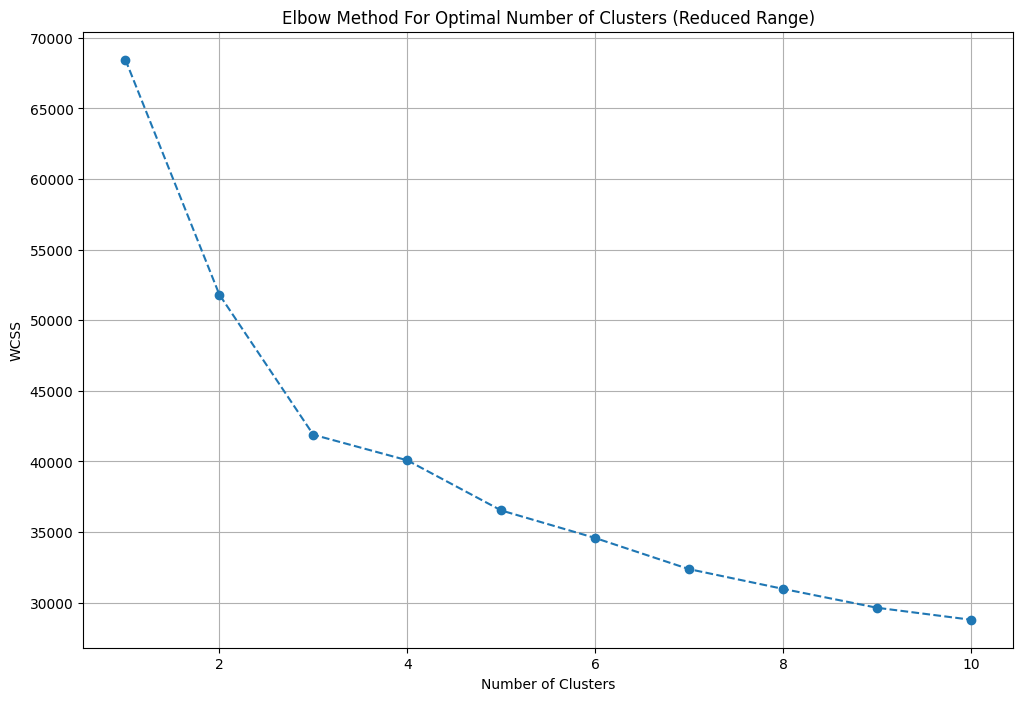

In [44]:
# Plot the results
plt.figure(figsize=(12, 8))
plt.plot(range(1,11), wcss_reduced, marker='o', linestyle='--')
plt.title('Elbow Method For Optimal Number of Clusters (Reduced Range)')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.grid(True)
plt.show()

In [45]:
n_clusters = 3

# Fit the KMeans model
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(scaled_data)

# Predict the cluster assignments for each row
cluster_assignments = kmeans.predict(scaled_data)

In [46]:
df = df.iloc[:,:-18]

In [47]:
df['furnishing_type'] = cluster_assignments

In [48]:
df.sample(5)[['furnishDetails','furnishing_type']]
# 0 -> unfurnished
# 1 -> semifurnished
# 2 -> furnished

,furnishDetails,furnishing_type
3772,NaN,1
2748,"['3 Wardrobe', '3 Fan', '1 Exhaust Fan', '3 Ge...",0
2926,NaN,1
27,"['8 Wardrobe', '4 Fan', '1 Exhaust Fan', '12 G...",0
169,"['9 Wardrobe', '15 Fan', '1 Exhaust Fan', '12 ...",0


## 5.features

In [49]:
df[['society','features']].sample(5)

,society,features
2117,sapphire eighty three,NaN
1733,dlf the ultima,"['Feng Shui / Vaastu Compliant', 'Security / F..."
2164,vatika gurgaon,"['Security / Fire Alarm', 'Feng Shui / Vaastu ..."
3327,independent,NaN
739,dlf carlton estate,"['Feng Shui / Vaastu Compliant', 'Intercom Fac..."


In [50]:
df['features'].isnull().sum()

np.int64(635)

In [51]:
import pandas as pd
app_df = pd.read_csv(f'{file_path}/appartments.csv')
app_df.head(2)

,PropertyName,PropertySubName,NearbyLocations,LocationAdvantages,Link,PriceDetails,TopFacilities
0,Smartworld One DXP,"2, 3, 4 BHK Apartment in Sector 113, Gurgaon","['Bajghera Road', 'Palam Vihar Halt', 'DPSG Pa...","{'Bajghera Road': '800 Meter', 'Palam Vihar Ha...",https://www.99acres.com/smartworld-one-dxp-sec...,"{'2 BHK': {'building_type': 'Apartment', 'area...","['Swimming Pool', 'Salon', 'Restaurant', 'Spa'..."
1,M3M Crown,"3, 4 BHK Apartment in Sector 111, Gurgaon","['DPSG Palam Vihar Gurugram', 'The NorthCap Un...","{'DPSG Palam Vihar Gurugram': '1.4 Km', 'The N...",https://www.99acres.com/m3m-crown-sector-111-g...,"{'3 BHK': {'building_type': 'Apartment', 'area...","['Bowling Alley', 'Mini Theatre', 'Manicured G..."


In [52]:
app_df['PropertyName'] = app_df['PropertyName'].str.lower()

In [53]:
temp_df = df[df['features'].isnull()]

In [54]:
temp_df.shape

(635, 26)

In [55]:
x = temp_df.merge(app_df,left_on='society',right_on='PropertyName',how='left')['TopFacilities']

In [56]:
df.loc[temp_df.index,'features'] = x.values

In [57]:
df['features'].isnull().sum()

np.int64(481)

In [58]:
from sklearn.preprocessing import MultiLabelBinarizer
import ast

In [59]:
# Convert the string representation of lists in the 'features' column to actual lists
df['features_list'] = df['features'].apply(lambda x: ast.literal_eval(x) if pd.notnull(x) and x.startswith('[') else [])

# Use MultiLabelBinarizer to convert the features list into a binary matrix
mlb = MultiLabelBinarizer()
features_binary_matrix = mlb.fit_transform(df['features_list'])

# Convert the binary matrix into a DataFrame
features_binary_df = pd.DataFrame(features_binary_matrix, columns=mlb.classes_)

In [60]:
features_binary_df.sample(5)

,24/7 Power Backup,24/7 Water Supply,24x7 Security,ATM,Aerobics Centre,Air Hockey,Airy Rooms,Amphitheatre,Automated Car Wash,Badminton Court,Bank Attached Property,Banquet Hall,Bar/Chill-Out Lounge,Barbecue,Basketball Court,Beach Volley Ball Court,Billiards,Bowling Alley,Bus Shelter,Business Lounge,CCTV Camera Security,Cafeteria,Car Parking,Car wash area,Card Room,Centrally Air Conditioned,Changing Area,Children's Play Area,Cigar Lounge,Clinic,Club House,Club house / Community Center,Community Hall,Concierge Service,Conference room,Creche/Day care,Cricket Pitch,Doctor on Call,Earthquake Resistant,Entrance Lobby,False Ceiling Lighting,Feng Shui / Vaastu Compliant,Fire Fighting Systems,Fitness Centre / GYM,Flower Garden,Food Court,Foosball,Football,Fountain,Gated Community,Gazebo,Golf Course,Grocery Shop,Gymnasium,High Ceiling Height,High Speed Elevators,Infinity Pool,Intercom Facility,Internal Street Lights,Internet/wi-fi connectivity,Jacuzzi,Jogging Track,Landscape Garden,Laundry,Lawn Tennis Court,Library,Lift(s),Lounge,Low Density Society,Maintenance Staff,Manicured Garden,Medical Centre,Milk Booth,Mini Theatre,Multipurpose Court,Multipurpose Hall,Natural Light,Natural Pond,No open drainage around,Park,Party Lawn,Pergola,Piped Gas,Piped-gas,Pool Table,Power Back up Lift,Power Back-up,Private Garden / Terrace,Property Staff,RO System,Rain Water Harvesting,Reading Lounge,Recently Renovated,Reflexology Park,Restaurant,Salon,Sauna,School,Security / Fire Alarm,Security Personnel,Separate entry for servant room,Sewage Treatment Plant,Shopping Centre,Skating Rink,Solar Lighting,Solar Water Heating,Spa,Spacious Interiors,Squash Court,Steam Room,Sun Deck,Swimming Pool,Temple,Terrace Garden,Theatre,Toddler Pool,Valet Parking,Vastu Compliant,Video Door Security,Visitor Parking,Visitors Parking,Volley Ball Court,Waiting Lounge,Waste Disposal,Water Softener Plant,Water Storage,Water purifier,Water softening plant,Wi-Fi Connectivity,Yoga/Meditation Area
3481,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
3349,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
110,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
410,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1908,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [61]:
features_binary_df.shape

(3803, 130)

In [62]:
wcss_reduced = []

for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(features_binary_df)
    wcss_reduced.append(kmeans.inertia_)

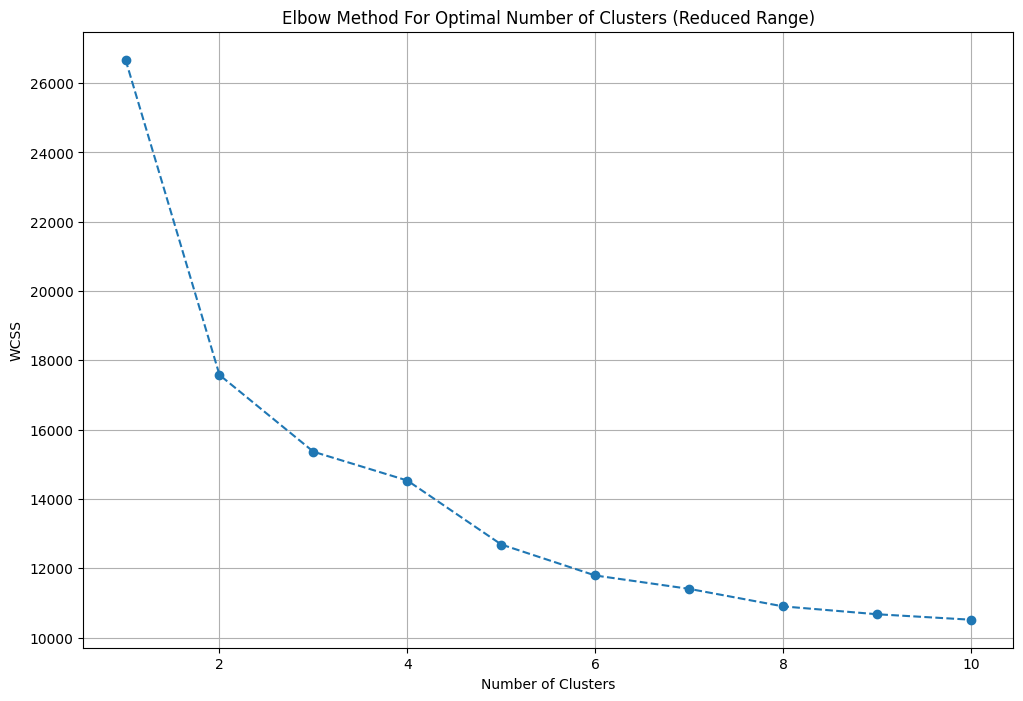

In [63]:
# Plot the results
plt.figure(figsize=(12, 8))
plt.plot(range(1,11), wcss_reduced, marker='o', linestyle='--')
plt.title('Elbow Method For Optimal Number of Clusters (Reduced Range)')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.grid(True)
plt.show()

In [64]:
# Define the weights for each feature as provided
# Assigning weights based on perceived luxury contribution
weights = {
    '24/7 Power Backup': 8,
    '24/7 Water Supply': 4,
    '24x7 Security': 7,
    'ATM': 4,
    'Aerobics Centre': 6,
    'Airy Rooms': 8,
    'Amphitheatre': 7,
    'Badminton Court': 7,
    'Banquet Hall': 8,
    'Bar/Chill-Out Lounge': 9,
    'Barbecue': 7,
    'Basketball Court': 7,
    'Billiards': 7,
    'Bowling Alley': 8,
    'Business Lounge': 9,
    'CCTV Camera Security': 8,
    'Cafeteria': 6,
    'Car Parking': 6,
    'Card Room': 6,
    'Centrally Air Conditioned': 9,
    'Changing Area': 6,
    "Children's Play Area": 7,
    'Cigar Lounge': 9,
    'Clinic': 5,
    'Club House': 9,
    'Concierge Service': 9,
    'Conference room': 8,
    'Creche/Day care': 7,
    'Cricket Pitch': 7,
    'Doctor on Call': 6,
    'Earthquake Resistant': 5,
    'Entrance Lobby': 7,
    'False Ceiling Lighting': 6,
    'Feng Shui / Vaastu Compliant': 5,
    'Fire Fighting Systems': 8,
    'Fitness Centre / GYM': 8,
    'Flower Garden': 7,
    'Food Court': 6,
    'Foosball': 5,
    'Football': 7,
    'Fountain': 7,
    'Gated Community': 7,
    'Golf Course': 10,
    'Grocery Shop': 6,
    'Gymnasium': 8,
    'High Ceiling Height': 8,
    'High Speed Elevators': 8,
    'Infinity Pool': 9,
    'Intercom Facility': 7,
    'Internal Street Lights': 6,
    'Internet/wi-fi connectivity': 7,
    'Jacuzzi': 9,
    'Jogging Track': 7,
    'Landscape Garden': 8,
    'Laundry': 6,
    'Lawn Tennis Court': 8,
    'Library': 8,
    'Lounge': 8,
    'Low Density Society': 7,
    'Maintenance Staff': 6,
    'Manicured Garden': 7,
    'Medical Centre': 5,
    'Milk Booth': 4,
    'Mini Theatre': 9,
    'Multipurpose Court': 7,
    'Multipurpose Hall': 7,
    'Natural Light': 8,
    'Natural Pond': 7,
    'Park': 8,
    'Party Lawn': 8,
    'Piped Gas': 7,
    'Pool Table': 7,
    'Power Back up Lift': 8,
    'Private Garden / Terrace': 9,
    'Property Staff': 7,
    'RO System': 7,
    'Rain Water Harvesting': 7,
    'Reading Lounge': 8,
    'Restaurant': 8,
    'Salon': 8,
    'Sauna': 9,
    'Security / Fire Alarm': 9,
    'Security Personnel': 9,
    'Separate entry for servant room': 8,
    'Sewage Treatment Plant': 6,
    'Shopping Centre': 7,
    'Skating Rink': 7,
    'Solar Lighting': 6,
    'Solar Water Heating': 7,
    'Spa': 9,
    'Spacious Interiors': 9,
    'Squash Court': 8,
    'Steam Room': 9,
    'Sun Deck': 8,
    'Swimming Pool': 8,
    'Temple': 5,
    'Theatre': 9,
    'Toddler Pool': 7,
    'Valet Parking': 9,
    'Video Door Security': 9,
    'Visitor Parking': 7,
    'Water Softener Plant': 7,
    'Water Storage': 7,
    'Water purifier': 7,
    'Yoga/Meditation Area': 7
}
# Calculate luxury score for each row
luxury_score = features_binary_df[list(weights.keys())].multiply(list(weights.values())).sum(axis=1)


In [65]:
df['luxury_score'] = luxury_score

In [66]:
df.head()

,property_type,society,sector,price,price_per_sqft,area,areaWithType,bedRoom,bathroom,balcony,additionalRoom,floorNum,facing,agePossession,nearbyLocations,furnishDetails,features,super_built_up_area,built_up_area,carpet_area,study room,servant room,store room,pooja room,others,furnishing_type,features_list,luxury_score
0,flat,apna enclave,sector 3,8.00,6153.0,13002.0,Super Built up area 1300(120.77 sq.m.)Built Up...,3,3,1,not available,0.0,NaN,Old Property,"['Chintapurni Mandir', 'Sheetla Mata Mandir', ...",NaN,NaN,1300.0,1000.0,NaN,0,0,0,0,0,1,[],0
1,flat,la vida by tata housing,sector 113,2.00,11346.0,1763.0,Super Built up area 2690(249.91 sq.m.)Built Up...,3,3,3,"study room,servant room",3.0,North,New Property,"['Dwarka Sector 21', 'Pacific D21 Mall', 'Bajg...","['2 Light', 'No AC', 'No Bed', 'No Chimney', '...","['Centrally Air Conditioned', 'Water purifier'...",2690.0,2599.0,2450.0,1,1,0,0,0,1,"[Centrally Air Conditioned, Water purifier, Se...",174
2,house,independent,sector 56,3.25,21495.0,1512.0,Plot area 168(140.47 sq.m.),5,6,3+,"pooja room,others",4.0,East,Relatively New,"['Sector metro station', 'Sector metro station...","['7 Wardrobe', '3 Fan', '1 Exhaust Fan', '8 Li...","['Maintenance Staff', 'Water Storage', 'Visito...",NaN,1512.0,NaN,0,0,0,1,1,0,"[Maintenance Staff, Water Storage, Visitor Par...",27
3,flat,g l s arawali homes,sohna road,2.00,4513.0,4432.0,Super Built up area 576(53.51 sq.m.),2,2,2,not available,1.0,NaN,Moderately Old,NaN,[],NaN,576.0,NaN,NaN,0,0,0,0,0,1,[],0
4,flat,tarc maceo,sector 91,9.00,5413.0,16627.0,Super Built up area 1404(130.44 sq.m.),2,2,3+,not available,8.0,East,Moderately Old,"['Manish Gallexie 91', 'Dwarka Expressway', 'R...","['2 Wardrobe', '4 Fan', '2 Geyser', '11 Light'...","['Security / Fire Alarm', 'Intercom Facility',...",1404.0,NaN,NaN,0,0,0,0,0,1,"[Security / Fire Alarm, Intercom Facility, Lif...",85


In [67]:
# cols to drop -> nearbyLocations,furnishDetails, features,features_list, additionalRoom
df.drop(columns=['nearbyLocations','furnishDetails','features','features_list','additionalRoom'],inplace=True)

In [68]:
df.sample(5)

,property_type,society,sector,price,price_per_sqft,area,areaWithType,bedRoom,bathroom,balcony,floorNum,facing,agePossession,super_built_up_area,built_up_area,carpet_area,study room,servant room,store room,pooja room,others,furnishing_type,luxury_score
2233,flat,sbtl caladium,sector 109,1.00,6153.0,1625.0,Super Built up area 3055(283.82 sq.m.),4,5,3,10.0,North-East,Relatively New,3055.0,NaN,NaN,0,0,0,0,0,1,110
1543,flat,eldeco accolade,sohna road,1.00,7549.0,1325.0,Super Built up area 1457(135.36 sq.m.),2,2,3+,17.0,NaN,Relatively New,1457.0,NaN,NaN,1,0,0,0,1,0,7
362,flat,bptp terra,sector 37d,1.00,8255.0,1211.0,Super Built up area 1811(168.25 sq.m.)Carpet a...,3,3,3,12.0,South-West,Relatively New,1811.0,NaN,1560.0,0,0,0,0,1,1,49
2808,house,independent,sector 37d,1.16,7539.0,1539.0,Built Up area: 1535 (142.61 sq.m.),1,1,0,1.0,NaN,Undefined,NaN,1535.0,NaN,0,0,0,0,0,1,0
1163,house,independent,sector 26,14.75,51864.0,2844.0,Plot area 316(264.22 sq.m.),16,20,3+,4.0,East,New Property,NaN,2844.0,NaN,1,1,1,1,0,0,153


In [69]:
df.shape

(3803, 23)

In [70]:
df.iloc[1254:]

,property_type,society,sector,price,price_per_sqft,area,areaWithType,bedRoom,bathroom,balcony,floorNum,facing,agePossession,super_built_up_area,built_up_area,carpet_area,study room,servant room,store room,pooja room,others,furnishing_type,luxury_score
1254,flat,parsvnath exotica,sector 53,6.00,19000.0,3158.0,Super Built up area 3390(314.94 sq.m.),4,4,3,7.0,West,Moderately Old,3390.0,NaN,NaN,0,1,0,0,0,0,80
1255,house,unitech espace,sector 50,7.45,34491.0,2160.0,Plot area 240(200.67 sq.m.)Built Up area: 4500...,4,4,3,3.0,NaN,Old Property,NaN,4500.0,4000.0,0,1,0,0,0,0,59
1256,flat,emaar mgf emerald floors premier,sector 65,2.00,14430.0,1386.0,Carpet area: 1975 (183.48 sq.m.),4,4,3,3.0,North,Relatively New,NaN,NaN,1975.0,1,1,0,0,0,1,28
1257,house,independent,sector 4,1.10,11111.0,990.0,Built Up area: 990 (91.97 sq.m.),6,4,1,2.0,North,Undefined,NaN,990.0,NaN,0,0,0,0,0,1,0
1258,flat,the roselia 2,sector 95,4.00,6475.0,6178.0,Built Up area: 695 (64.57 sq.m.)Carpet area: 5...,2,2,2,19.0,North,Undefined,NaN,695.0,595.0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3798,flat,orris aster court premier,sector 85,1.00,5896.0,1696.0,Super Built up area 2120(196.95 sq.m.)Built Up...,3,4,2,5.0,North,Relatively New,2120.0,1900.0,1800.0,0,1,0,0,0,0,174
3799,flat,supertech araville,sector 79,7.00,6024.0,11620.0,Super Built up area 1295(120.31 sq.m.),2,2,3+,0.0,NaN,New Property,1295.0,NaN,NaN,0,0,0,0,1,1,74
3800,flat,spaze privvy the address,sector 93,1.00,6900.0,1449.0,Super Built up area 1805(167.69 sq.m.)Built Up...,3,4,2,12.0,North-East,Relatively New,1805.0,1350.0,1100.0,0,0,0,0,0,0,96
3801,flat,dlf wellington estate,sector 43,2.00,14615.0,1368.0,Super Built up area 1430(132.85 sq.m.),3,3,2,11.0,West,Old Property,1430.0,NaN,NaN,0,0,0,0,0,0,79


In [71]:
df.to_csv(f'{file_path}/5.gurgaon_properties_cleaned_v2.csv',index=False)